## TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL

### finetuning a pre-trained Mask R-CNN model on the Penn-Fudan Database for Pedestrian Detection and Segmentation

#### Defining the Dataset

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from PIL import Image

In [5]:
#in this part,there is no transform.v2 in the following code
#it may do not work on train or evaluation 

class PennFudanDataset(Dataset):
    def __init__(self,root,transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root,"PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root,"PedMasks"))))
        
    def __getitem__(self,idx):
        img_path = os.path.join(self.root,"PNGImages",self.imgs[idx])
        mask_path = os.path.join(self.root,"PedMasks",self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        image_id = torch.as_tensor(idx)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
image_path = './PennFudanPed/PennFudanPed/PNGImages/FudanPed00001.png'
mask_path = './PennFudanPed/PennFudanPed/PedMasks/FudanPed00001_mask.png'

In [7]:
image = read_image(image_path)
mask = read_image(mask_path)

In [8]:
image

tensor([[[211, 210, 212,  ..., 143, 146, 148],
         [179, 173, 170,  ..., 126, 128, 128],
         [204, 194, 188,  ..., 130, 131, 130],
         ...,
         [226, 217, 211,  ..., 183, 184, 185],
         [231, 219, 210,  ..., 187, 187, 186],
         [225, 227, 215,  ..., 190, 190, 187]],

        [[200, 199, 201,  ...,  96,  99, 101],
         [168, 162, 159,  ...,  79,  81,  81],
         [193, 183, 177,  ...,  83,  84,  83],
         ...,
         [220, 211, 205,  ..., 183, 184, 185],
         [225, 213, 204,  ..., 187, 187, 186],
         [219, 221, 209,  ..., 190, 190, 187]],

        [[182, 181, 183,  ...,  78,  81,  83],
         [150, 144, 141,  ...,  61,  63,  63],
         [175, 165, 159,  ...,  65,  66,  65],
         ...,
         [220, 211, 205,  ..., 183, 184, 185],
         [225, 213, 204,  ..., 187, 187, 186],
         [219, 221, 209,  ..., 190, 190, 187]]], dtype=torch.uint8)

In [9]:
mask

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [10]:
mask.size()

torch.Size([1, 536, 559])

In [11]:
obj_ids = torch.unique(mask)

In [12]:
obj_ids[:, None, None]

tensor([[[0]],

        [[1]],

        [[2]]], dtype=torch.uint8)

In [13]:
mask == obj_ids[:, None, None]

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [14]:
masks = (mask == obj_ids[:, None, None]).to(dtype = torch.uint8)

In [15]:
masks

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [16]:
boxes = masks_to_boxes(masks)

In [17]:
boxes

tensor([[  0.,   0., 558., 535.],
        [159., 181., 301., 430.],
        [419., 170., 534., 485.]])

In [18]:
root = './PennFudanPed/PennFudanPed/'

In [19]:
PennFudan_Dataset = PennFudanDataset(root,None)

In [20]:
PennFudan_Dataset.masks

['FudanPed00001_mask.png',
 'FudanPed00002_mask.png',
 'FudanPed00003_mask.png',
 'FudanPed00004_mask.png',
 'FudanPed00005_mask.png',
 'FudanPed00006_mask.png',
 'FudanPed00007_mask.png',
 'FudanPed00008_mask.png',
 'FudanPed00009_mask.png',
 'FudanPed00010_mask.png',
 'FudanPed00011_mask.png',
 'FudanPed00012_mask.png',
 'FudanPed00013_mask.png',
 'FudanPed00014_mask.png',
 'FudanPed00015_mask.png',
 'FudanPed00016_mask.png',
 'FudanPed00017_mask.png',
 'FudanPed00018_mask.png',
 'FudanPed00019_mask.png',
 'FudanPed00020_mask.png',
 'FudanPed00021_mask.png',
 'FudanPed00022_mask.png',
 'FudanPed00023_mask.png',
 'FudanPed00024_mask.png',
 'FudanPed00025_mask.png',
 'FudanPed00026_mask.png',
 'FudanPed00027_mask.png',
 'FudanPed00028_mask.png',
 'FudanPed00029_mask.png',
 'FudanPed00030_mask.png',
 'FudanPed00031_mask.png',
 'FudanPed00032_mask.png',
 'FudanPed00033_mask.png',
 'FudanPed00034_mask.png',
 'FudanPed00035_mask.png',
 'FudanPed00036_mask.png',
 'FudanPed00037_mask.png',
 

In [21]:
len(PennFudan_Dataset)

170

In [22]:
PennFudan_Dataset.__getitem__(0)

(tensor([[[211, 210, 212,  ..., 143, 146, 148],
          [179, 173, 170,  ..., 126, 128, 128],
          [204, 194, 188,  ..., 130, 131, 130],
          ...,
          [226, 217, 211,  ..., 183, 184, 185],
          [231, 219, 210,  ..., 187, 187, 186],
          [225, 227, 215,  ..., 190, 190, 187]],
 
         [[200, 199, 201,  ...,  96,  99, 101],
          [168, 162, 159,  ...,  79,  81,  81],
          [193, 183, 177,  ...,  83,  84,  83],
          ...,
          [220, 211, 205,  ..., 183, 184, 185],
          [225, 213, 204,  ..., 187, 187, 186],
          [219, 221, 209,  ..., 190, 190, 187]],
 
         [[182, 181, 183,  ...,  78,  81,  83],
          [150, 144, 141,  ...,  61,  63,  63],
          [175, 165, 159,  ...,  65,  66,  65],
          ...,
          [220, 211, 205,  ..., 183, 184, 185],
          [225, 213, 204,  ..., 187, 187, 186],
          [219, 221, 209,  ..., 190, 190, 187]]], dtype=torch.uint8),
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 1

#### Defining model

##### There are two common situations where one might want to modify one of the available models in TorchVision Model Zoo. The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).
##### 也就是有两种情况，一个是我们使用预训练的模型，只是微调最后一层分类的类别；另外一个是我们需要更换骨干网络（比如，为了更快的预测）

##### 1.Finetuning from a pretrained model

In [23]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [24]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [25]:
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features

In [26]:
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

##### 2.Modifying the model to add a different backbone

In [27]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [28]:
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features

In [29]:
backbone.out_channels = 1280

In [30]:
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

In [31]:
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2,
)

In [32]:
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

#### Object detection and instance segmentation model for PennFudan Dataset

In [1]:
#Using transforms.v2,the new version of transforms

import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes,
    )

    return model

In [4]:
#create transformations
from torchvision.transforms import v2 as T

In [5]:
def get_transfom(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    # transforms.append(T.ToDtype(torch.float,scale=True)) 
    # this a strange step,if we want to visualize some images,the scale should be False,but in train, it should be True,
    # so that the value of image is torch.float in the range of [0,1]
    transforms.append(T.ToPureTensor())
    
    return T.Compose(transforms)

In [6]:
from detection import utils

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [8]:
dataset = PennFudanDataset('./PennFudanPed/PennFudanPed',get_transfom(train = True))

In [9]:
from torch.utils.data import DataLoader

In [10]:
dataloader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

In [11]:
images,targets = next(iter(dataloader))

In [12]:
images = list(image for image in images)

In [13]:
images

[tensor([[[ 61,  60,  44,  ...,  31,  27,  31],
          [ 45,  44,  42,  ...,  41,  37,  38],
          [ 41,  37,  47,  ...,  41,  36,  32],
          ...,
          [169, 170, 168,  ..., 156, 158, 160],
          [170, 170, 167,  ..., 161, 160, 158],
          [171, 170, 169,  ..., 166, 166, 165]],
 
         [[ 77,  76,  61,  ...,  43,  38,  42],
          [ 61,  58,  59,  ...,  52,  48,  49],
          [ 55,  49,  61,  ...,  54,  49,  45],
          ...,
          [169, 170, 168,  ..., 156, 158, 160],
          [170, 170, 167,  ..., 161, 160, 158],
          [171, 170, 169,  ..., 166, 166, 165]],
 
         [[ 64,  63,  43,  ...,  23,  21,  25],
          [ 48,  43,  41,  ...,  35,  31,  32],
          [ 40,  35,  44,  ...,  37,  32,  28],
          ...,
          [167, 168, 166,  ..., 154, 156, 158],
          [168, 168, 165,  ..., 159, 158, 156],
          [169, 168, 167,  ..., 164, 164, 163]]], dtype=torch.uint8),
 tensor([[[154, 185, 141,  ...,  51,  54,  53],
          [154,

In [14]:
len(images)

2

In [15]:
targets = [{k:v for k,v in t.items()} for t in targets]

In [16]:
targets

[{'boxes': tensor([[340.,  85., 465., 382.],
          [145.,  93., 266., 360.],
          [ 50., 100., 134., 377.]]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'labels': tensor([1, 1, 1]),
  'image_id': 15,
  'area': tensor([37125., 32307., 23268.]),
  'iscrowd': tensor([0, 0, 0])},
 {

In [24]:
targets[0]["labels"]

tensor([1, 1, 1])

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

In [18]:
def show(imgs):
    if not isinstance(imgs,list):
        imgs = [imgs]
    fix,axs = plt.subplots(ncols=len(imgs),squeeze=False,figsize=(15, 5))
    for i ,img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0,i].imshow(np.asarray(img))
        axs[0,i].set(xticklabels = [],yticklabels = [],xticks = [],yticks = [])

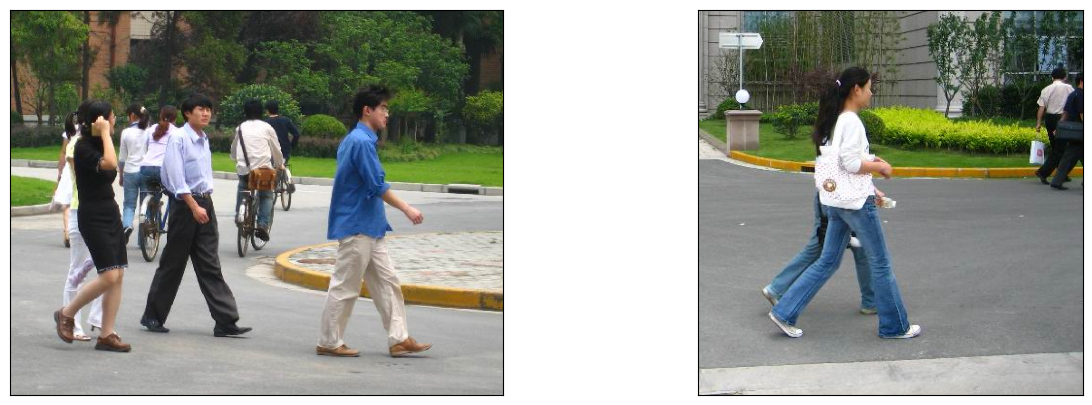

In [19]:
#we can show some batch images, bounding box,and masks 
show(images)

In [20]:
from torchvision.utils import draw_bounding_boxes,draw_segmentation_masks

In [21]:
images

[tensor([[[ 61,  60,  44,  ...,  31,  27,  31],
          [ 45,  44,  42,  ...,  41,  37,  38],
          [ 41,  37,  47,  ...,  41,  36,  32],
          ...,
          [169, 170, 168,  ..., 156, 158, 160],
          [170, 170, 167,  ..., 161, 160, 158],
          [171, 170, 169,  ..., 166, 166, 165]],
 
         [[ 77,  76,  61,  ...,  43,  38,  42],
          [ 61,  58,  59,  ...,  52,  48,  49],
          [ 55,  49,  61,  ...,  54,  49,  45],
          ...,
          [169, 170, 168,  ..., 156, 158, 160],
          [170, 170, 167,  ..., 161, 160, 158],
          [171, 170, 169,  ..., 166, 166, 165]],
 
         [[ 64,  63,  43,  ...,  23,  21,  25],
          [ 48,  43,  41,  ...,  35,  31,  32],
          [ 40,  35,  44,  ...,  37,  32,  28],
          ...,
          [167, 168, 166,  ..., 154, 156, 158],
          [168, 168, 165,  ..., 159, 158, 156],
          [169, 168, 167,  ..., 164, 164, 163]]], dtype=torch.uint8),
 tensor([[[154, 185, 141,  ...,  51,  54,  53],
          [154,

In [35]:
batch_imgs = []
batch_draw_boxes = []
batch_draw_masks = []
batch_combinations = []
for i in range(len(images)):
    batch_imgs.append(images[i].to(torch.uint8))
    draw_bboxes = draw_bounding_boxes(images[i].to(torch.uint8),targets[i]["boxes"],width=5,colors="Red")
    draw_seg_masks = draw_segmentation_masks(images[i].to(torch.uint8),targets[i]["masks"].to(bool),alpha=0.7)
    batch_draw_boxes.append(draw_bboxes)
    batch_draw_masks.append(draw_seg_masks)
    draw_combination = draw_segmentation_masks(draw_bboxes,targets[i]["masks"].to(bool),alpha=0.7)
    batch_combinations.append(draw_combination)

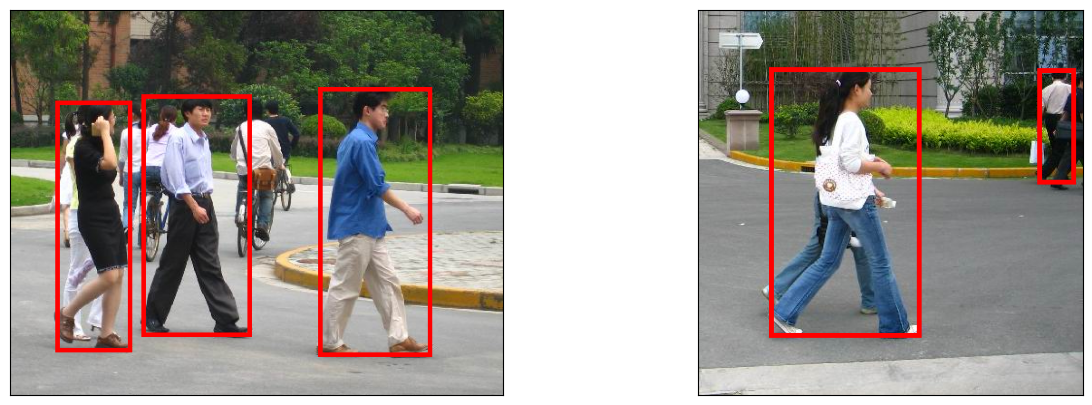

In [36]:
#just boxes
show(batch_draw_boxes)

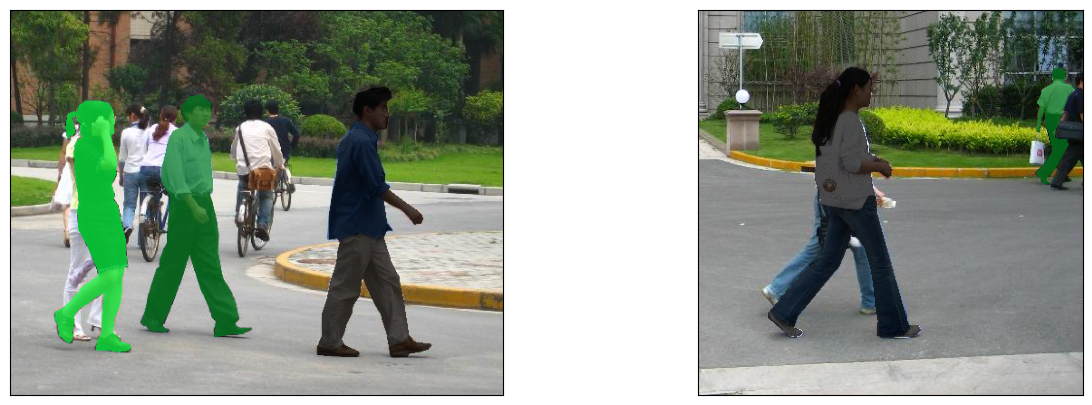

In [37]:
#just masks
show(batch_draw_masks)

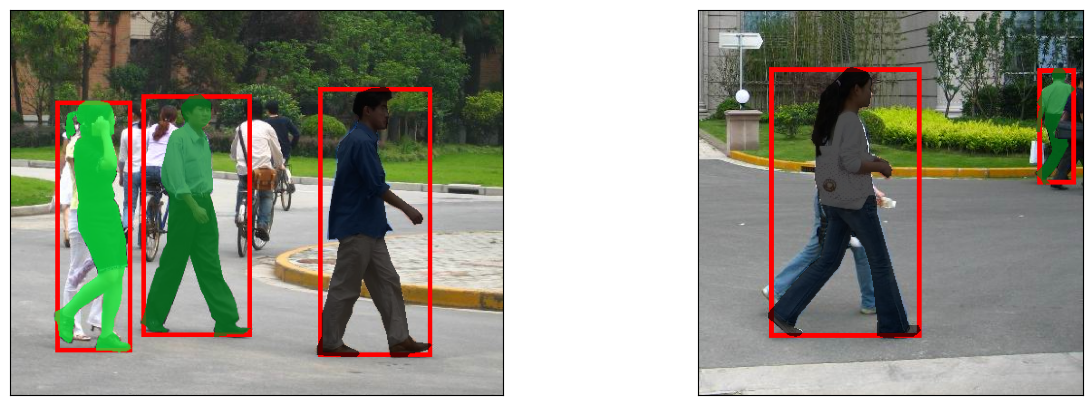

In [38]:
#boxes and masks 
show(batch_combinations)

In [7]:
def get_transfom(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float,scale=True)) 
    # this a strange step,if we want to visualize some images,the scale should be False,but in train, it should be True,
    # so that the value of image is torch.float in the range of [0,1]
    transforms.append(T.ToPureTensor())
    
    return T.Compose(transforms)

In [105]:
dataset = PennFudanDataset('./PennFudanPed/PennFudanPed',get_transfom(train = True))

In [106]:
dataloader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

In [107]:
images,targets = next(iter(dataloader))

In [108]:
images = list(image for image in images)

In [109]:
targets = [{k:v for k,v in t.items()} for t in targets]

In [110]:
#then train one batch to show losses and detections
output = model(images,targets)

In [111]:
print(output)

{'loss_classifier': tensor(0.2477, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0641, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0334, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0055, grad_fn=<DivBackward0>)}


In [112]:
#for inference
model.eval()
x = [torch.rand(3,300,400),torch.rand(3,500,400)] #randomly create two tensor for reference
prediction = model(x)
print(prediction[0])

{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


##### Now we start training and validating

In [15]:
#Using transforms.v2,the new version of transforms

import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes,
    )

    return model

In [17]:
def get_transfom(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float,scale=True)) 
    # this a strange step,if we want to visualize some images,the scale should be False,but in train, it should be True,
    # so that the value of image is torch.float in the range of [0,1]
    transforms.append(T.ToPureTensor())
    
    return T.Compose(transforms)

In [ ]:
from detection.engine import train_one_epoch,evaluate

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [20]:
num_classes =2
train_dataset = PennFudanDataset('./PennFudanPed/PennFudanPed',get_transfom(train=True))
test_dataset = PennFudanDataset('./PennFudanPed/PennFudanPed',get_transfom(train=False))

In [22]:
indices = torch.randperm(len(train_dataset)).tolist()

In [23]:
len(indices)

170

In [25]:
torch.randperm(len(train_dataset))

tensor([ 50, 102,  29, 115,  21, 138,  73, 166, 136,  70, 124,  62, 134,  76,
          5,  39,  57,  91,  32, 103, 128,  33, 154, 160, 151,  71, 129,   9,
         53, 118,  66,  16, 169,   7,  85,  88,  36, 131,  37,  45, 135,  67,
          1,  78, 147,  11, 143, 161,  47, 100, 133, 112,  74,  84, 127,  25,
         12, 140, 164,  92,  65,  43, 125,  26, 156,  20, 144,  79,  61, 162,
        104, 107,  38,  90, 146, 155, 145,   6, 152, 111,  60,  48, 101, 108,
         18,  41,  40,  56,  93,  77, 158,  96,  83, 157,  69, 163,  80,  10,
         87,  86, 148,  72, 105, 167, 110,   8,  30,  59,  55,  44, 130, 113,
         98,  49,  24,  75, 168,  51,   3,  27, 117, 141,  68,   0,  63, 159,
         46, 106, 139,  54, 123,  89, 165, 142,  52,  58, 120,  42,  13,  14,
         15,  31,  34,  82,  94,  28,  81, 126, 149,  99,   4,  97, 132,  35,
        122,  19,   2, 137, 121,  64,  17,  95, 109, 116, 119,  23, 153, 114,
         22, 150])

In [26]:
train_dataset = torch.utils.data.Subset(train_dataset,indices[:-50])
test_dataset = torch.utils.data.Subset(test_dataset,indices[-50:])

In [27]:
len(indices[:-50])

120

In [1]:
import os
import sys

In [2]:
sys.path.append('..')

In [3]:
sys.path.append('.')

In [4]:
sys.path

['e:\\jupyterlab\\PyTorch Tutorial\\PyTorch official\\TorchVision Object Detection Finetuning Tutorial',
 'e:\\Anaconda\\envs\\PyTorch2.0\\python310.zip',
 'e:\\Anaconda\\envs\\PyTorch2.0\\DLLs',
 'e:\\Anaconda\\envs\\PyTorch2.0\\lib',
 'e:\\Anaconda\\envs\\PyTorch2.0',
 '',
 'e:\\Anaconda\\envs\\PyTorch2.0\\lib\\site-packages',
 'e:\\Anaconda\\envs\\PyTorch2.0\\lib\\site-packages\\win32',
 'e:\\Anaconda\\envs\\PyTorch2.0\\lib\\site-packages\\win32\\lib',
 'e:\\Anaconda\\envs\\PyTorch2.0\\lib\\site-packages\\Pythonwin',
 '..',
 '.']

In [2]:
from torch.utils.data import DataLoader
# from PyTorchreferences.detection import utils
from detection import utils

In [32]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

In [33]:
model = get_model_instance_segmentation(num_classes)
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [34]:
#we only optim parameters that have requires_grad,need to be updated
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr = 0.005,
    momentum=0.9,
    weight_decay=0.0005
)

In [35]:
#learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size = 3,
    gamma = 0.1
)

In [36]:
num_epochs = 5

In [37]:
for epoch in range(num_epochs):
    train_one_epoch(model,optimizer,train_dataloader,device,epoch,print_freq=10)
    lr_scheduler.step() #update learning rate
    torch.cuda.empty_cache()
    evaluate(model,test_dataloader,device) #evaluate on the test data
    torch.cuda.empty_cache()

Epoch: [0]  [ 0/60]  eta: 0:17:27  lr: 0.000090  loss: 3.1877 (3.1877)  loss_classifier: 0.6433 (0.6433)  loss_box_reg: 0.4969 (0.4969)  loss_mask: 2.0241 (2.0241)  loss_objectness: 0.0076 (0.0076)  loss_rpn_box_reg: 0.0159 (0.0159)  time: 17.4562  data: 0.1971  max mem: 2540
Epoch: [0]  [10/60]  eta: 0:02:20  lr: 0.000936  loss: 1.5746 (1.9349)  loss_classifier: 0.5096 (0.4320)  loss_box_reg: 0.3077 (0.2997)  loss_mask: 0.7354 (1.1753)  loss_objectness: 0.0185 (0.0210)  loss_rpn_box_reg: 0.0042 (0.0068)  time: 2.8191  data: 0.0994  max mem: 2758
Epoch: [0]  [20/60]  eta: 0:01:21  lr: 0.001783  loss: 0.8412 (1.3406)  loss_classifier: 0.1904 (0.3021)  loss_box_reg: 0.2675 (0.2866)  loss_mask: 0.3229 (0.7248)  loss_objectness: 0.0185 (0.0209)  loss_rpn_box_reg: 0.0042 (0.0063)  time: 1.2544  data: 0.0701  max mem: 2758
